In [1]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import torch
import torchaudio
import time

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, FDSTFT, entropy_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1802);
device

'cuda'

In [2]:
sr = 1e4; support = 1_000; stride = 100; lr = 10; winlength = 200
epochs = 1_000_000; threeshold= .01; patience = 99

t = torch.arange(0, 2.5, 1/sr)
f = (torch.sin(2*pi*t) + torch.ones_like(t) + .5 * t)
f = f/f.max()*0.5*sr/2

#plt.plot(f)
#plt.ylim(top=.5*sr, bottom=0)
#plt.xlim(left=0, right=25_000)


x = torch.sin(2*pi*torch.cumsum(f/sr, dim=0) ) 
x += torch.sin(2*pi*torch.cumsum(0.8/2* torch.ones_like(t), dim=0))
x += 0.1 *torch.randn(t.shape)

#plt.figure()
#plt.plot(x[:500])

x = x[None, ...].to(device)
#f = f.to(device)
print(x.shape)

winlengths = {}
grads = {}
times = {}
losses = {}

torch.Size([1, 25000])


Epoch 00152: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00252: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00352: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00452: reducing learning rate of group 0 to 1.0000e-03.
451 495.9


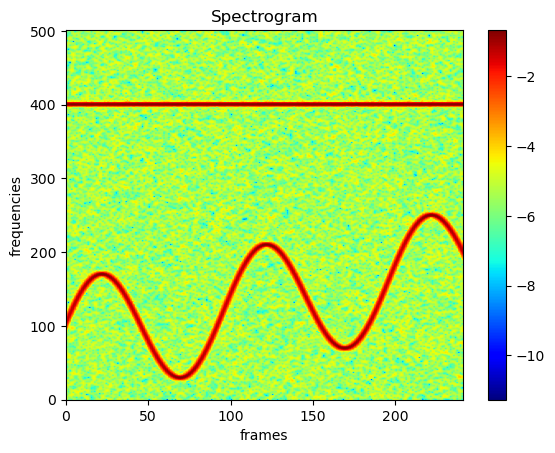

In [3]:
key = 'pytorch'
winlengths[key] = []
grads[key] = []
times[key] = []

dstft = FDSTFT(x, win_length=winlength, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': lr}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

min_err = 100
min_win = 0

for epoch in range(epochs):
    
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    start_time = time.time()
    err.backward()    
    dt = time.time() - start_time
    opt.step()
    sch.step(err)
    
    winlengths[key].append(dstft.win_length.item())
    grads[key].append(dstft.win_length.grad.item())
    times[key].append(dt)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < threeshold:
        break

losses[key] = entropy_loss(spec).item()
print(epoch, f'{dstft.win_length.item():.1f}')
dstft.print(spec, x, bar=True, wins=False, weights=False)

Epoch 00101: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00201: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00301: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00401: reducing learning rate of group 0 to 1.0000e-03.
400 -988.0


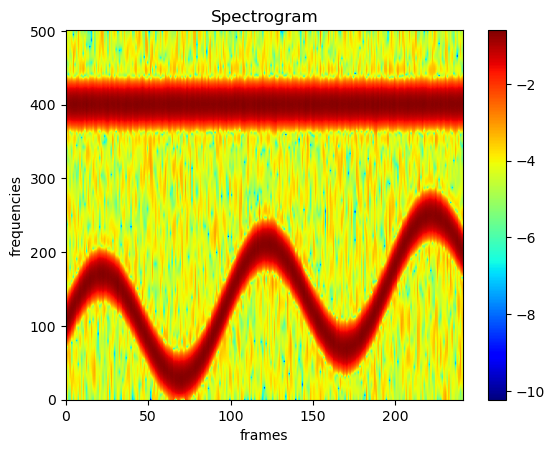

In [4]:
key = 'ours'
winlengths[key] = []
grads[key] = []
times[key] = []

dstft = FDSTFT(x, win_length=winlength, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': lr}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

min_err = 100
min_win = 0

for epoch in range(epochs):
    
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)    
    start_time = time.time()
    dl_ds = torch.autograd.grad(err, stft)[0]
    dl_dp = dstft.backward(x, dl_ds)   
    dt = time.time() - start_time
    dstft.win_length.grad = dl_dp
    opt.step()
    sch.step(err)
    
    winlengths[key].append(dstft.win_length.item())
    grads[key].append(dstft.win_length.grad.item())
    times[key].append(dt)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < threeshold:
        break

losses[key] = entropy_loss(spec).item()
print(epoch, f'{dstft.win_length.item():.1f}')
dstft.print(spec, x, bar=True, wins=False, weights=False)

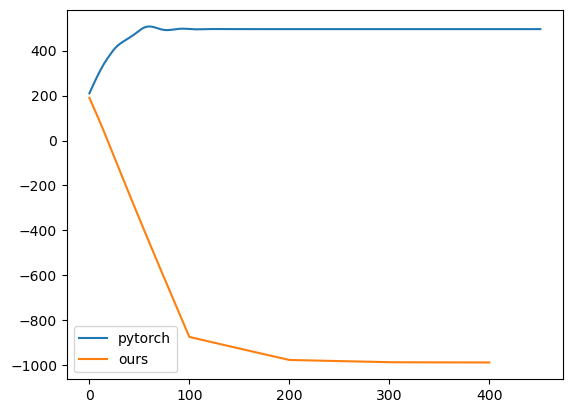

<Figure size 640x480 with 0 Axes>

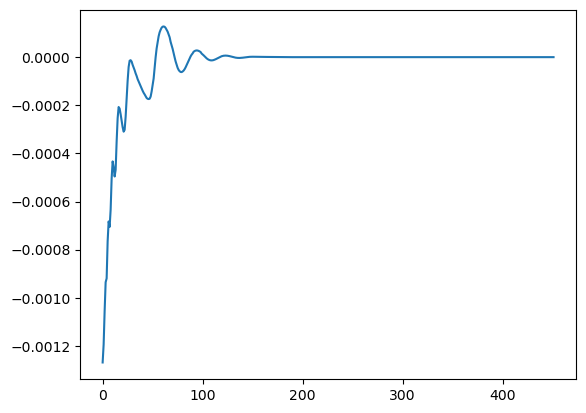

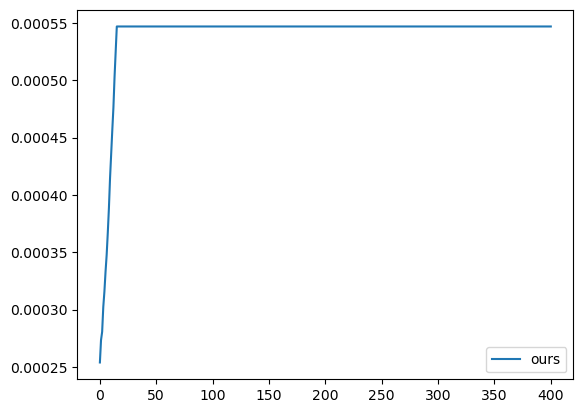

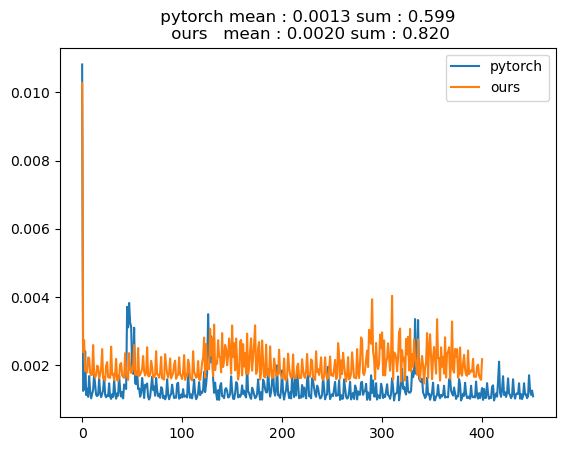

In [5]:
plt.figure()
for key in winlengths.keys():
    plt.plot(winlengths[key], label=key)
plt.legend()

plt.figure()
for key in grads.keys():
    plt.figure()
    plt.plot(grads[key], label=key)
plt.legend()

plt.figure()
for key in times.keys():
    plt.plot(times[key], label=key)
plt.legend()
plt.title(f""" pytorch mean : {np.mean(times['pytorch']):.4f} sum : {np.sum(times['pytorch']):.3f} \n ours   mean : {np.mean(times['ours']):.4f} sum : {np.sum(times['ours']):.3f}""");


496


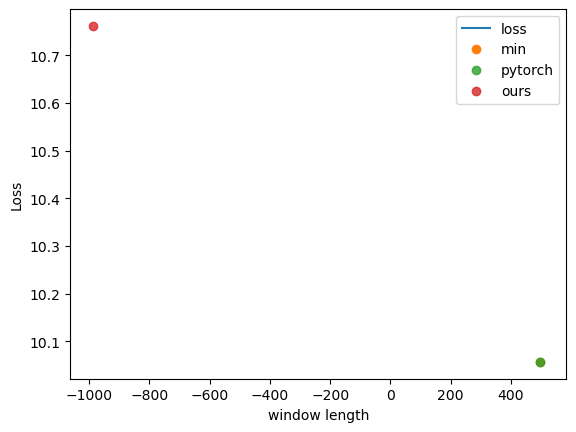

In [6]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(490, 510, 1):
    dstft = FDSTFT(x, win_length=win_length, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(490, 510, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')
plt.plot(winlengths['pytorch'][-1], losses['pytorch'], 'o', alpha=.8, label='pytorch')
plt.plot(winlengths['ours'][-1], losses['ours'], 'o', alpha=.8, label='ours')
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()
plt.show()